# 04 - Statistical Models

Regression, clustering, and time series analysis on football transfer market data.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

plt.rcParams.update({
    'figure.facecolor': '#0a0a0f', 'axes.facecolor': '#111118',
    'axes.edgecolor': '#1e1e2e', 'axes.labelcolor': '#8888a0',
    'text.color': '#e8e8f0', 'xtick.color': '#555568', 'ytick.color': '#555568',
    'grid.color': '#1e1e2e', 'grid.alpha': 0.5, 'font.family': 'monospace',
    'axes.titlecolor': '#fb8b1e', 'axes.titleweight': 'bold', 'axes.titlesize': 12,
})
ORANGE, CYAN, RED = '#fb8b1e', '#4af6c3', '#ff433d'
COLORS = [ORANGE, CYAN, '#3b82f6', '#a855f7', '#22d3ee']
LEAGUE_NAMES = {'GB1': 'Premier League', 'ES1': 'La Liga', 'IT1': 'Serie A',
                'L1': 'Bundesliga', 'FR1': 'Ligue 1'}
BIG5 = list(LEAGUE_NAMES.keys())

DB_PATH = Path('..') / 'data' / 'processed' / 'football.db'
conn = sqlite3.connect(DB_PATH)
print(f"Connected: {DB_PATH}")

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


Connected: ..\data\processed\football.db


## 1. Age-Value Regression (Quadratic Fit by Position)

Position              R²   Peak Age
-----------------------------------
Attack             0.026         26
Midfield           0.036         26
Defender           0.039         26
Goalkeeper         0.050         29


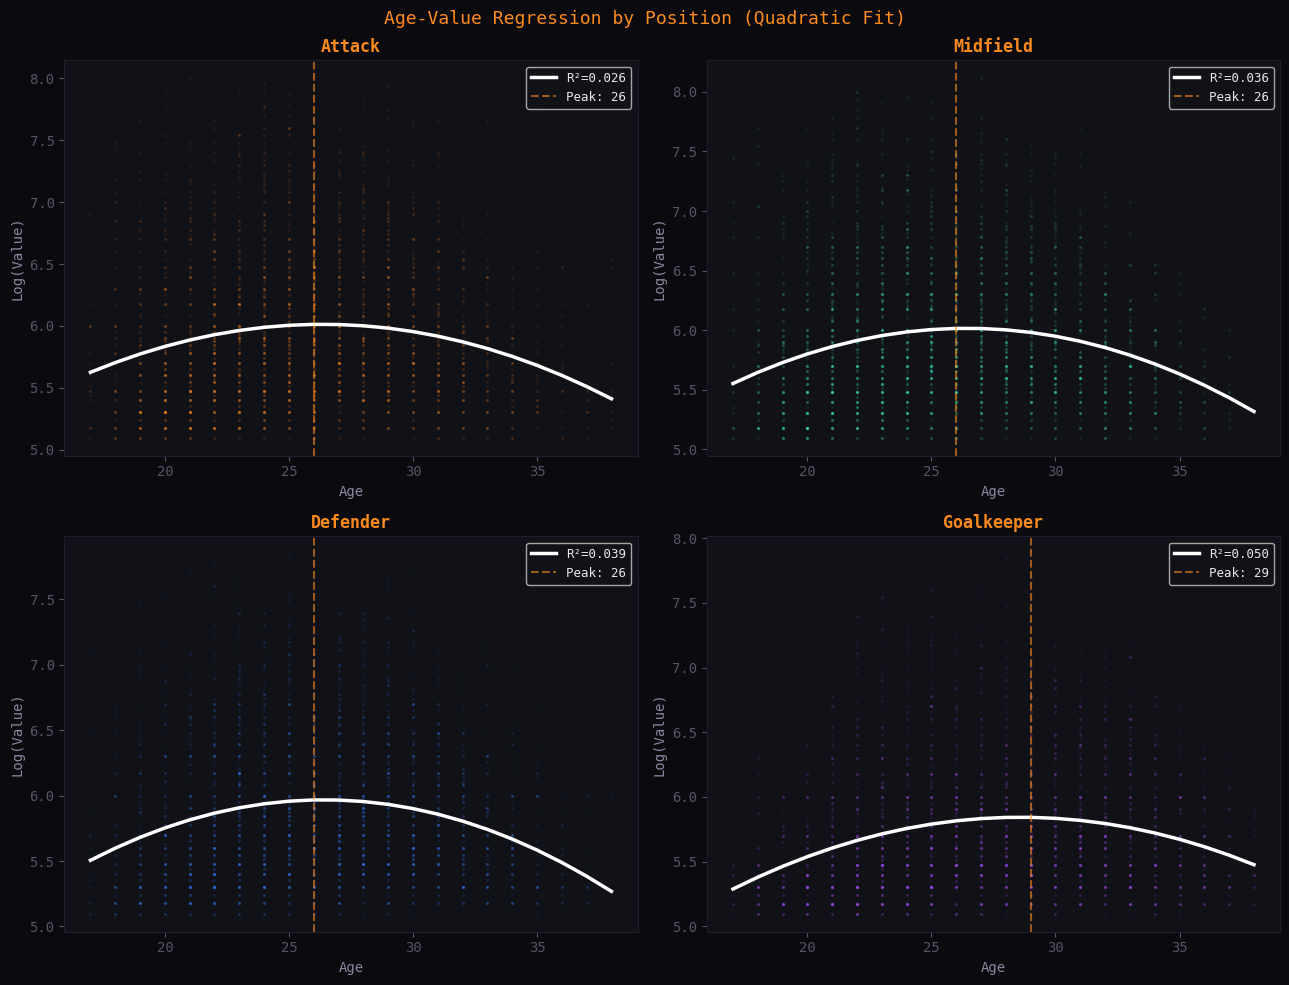

In [2]:

SQL = '''
    SELECT
        p.position,
        CAST((julianday(pv.date) - julianday(p.date_of_birth)) / 365.25 AS INTEGER) as age,
        LOG(pv.market_value_in_eur) as log_value
    FROM player_valuations pv
    JOIN players p ON pv.player_id = p.player_id
    WHERE p.position IN ('Attack', 'Midfield', 'Defender', 'Goalkeeper')
      AND p.date_of_birth IS NOT NULL
      AND pv.market_value_in_eur > 100000
      AND pv.date >= '2015-01-01'
'''
df = pd.read_sql(SQL, conn)
df = df[(df['age'] >= 17) & (df['age'] <= 38)].dropna()

fig, axes = plt.subplots(2, 2, figsize=(13, 10))
axes = axes.flatten()
pos_colors = {'Attack': ORANGE, 'Midfield': CYAN, 'Defender': '#3b82f6', 'Goalkeeper': '#a855f7'}

print(f"{'Position':<15} {'R²':>8} {'Peak Age':>10}")
print('-' * 35)

for i, (pos, color) in enumerate(pos_colors.items()):
    sub = df[df['position'] == pos]
    ages = np.arange(17, 39)
    X = np.column_stack([sub['age'], sub['age']**2])
    model = LinearRegression().fit(X, sub['log_value'])
    r2 = r2_score(sub['log_value'], model.predict(X))
    X_pred = np.column_stack([ages, ages**2])
    y_pred = model.predict(X_pred)
    peak_age = ages[np.argmax(y_pred)]
    print(f"{pos:<15} {r2:>8.3f} {peak_age:>10}")
    sub_sample = sub.sample(min(3000, len(sub)), random_state=42)
    axes[i].scatter(sub_sample['age'], sub_sample['log_value'], alpha=0.05, color=color, s=2)
    axes[i].plot(ages, y_pred, color='white', linewidth=2.5, label=f'R²={r2:.3f}')
    axes[i].axvline(x=peak_age, color=ORANGE, linestyle='--', alpha=0.6, label=f'Peak: {peak_age}')
    axes[i].set_title(pos); axes[i].set_xlabel('Age'); axes[i].set_ylabel('Log(Value)')
    axes[i].legend(fontsize=9)

plt.suptitle('Age-Value Regression by Position (Quadratic Fit)', color='#fb8b1e', fontsize=13)
plt.tight_layout()
plt.savefig('../data/processed/fig_regression.png', dpi=120, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()


## 2. Club Tier Segmentation -- K-Means (K=4)

Cluster Summary:


,squad_value_m,average_age,squad_size,transfer_activity
tier,,,,
Elite,178.7,28.7,14.4,20.8
Lower-Mid,22.7,27.0,12.5,3.9
Mid,30.0,27.4,14.9,56.2
Top-Mid,34.7,27.0,20.7,7.8


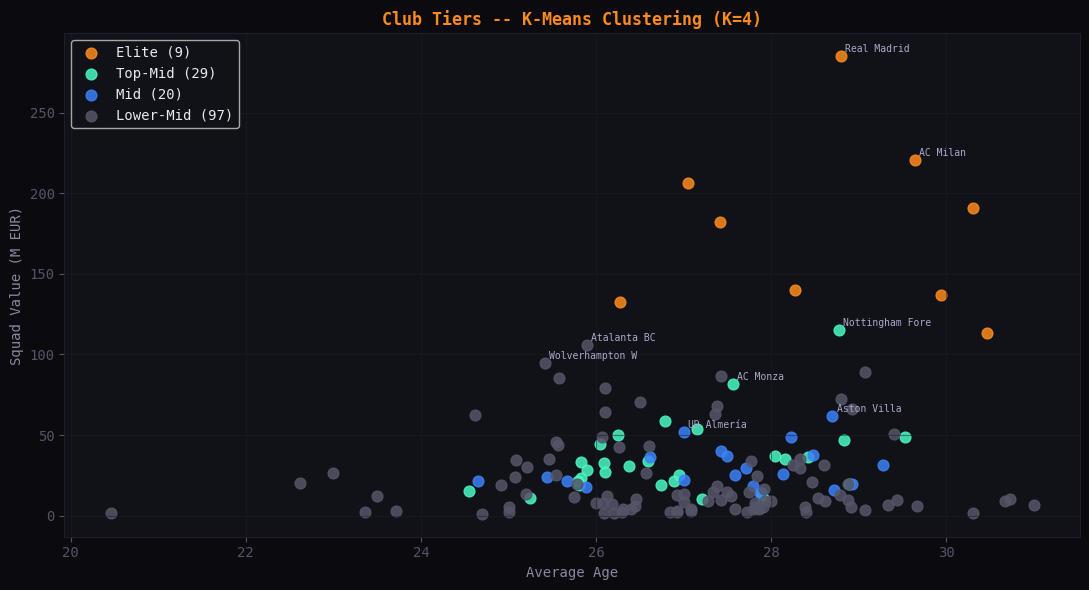

In [3]:

SQL = '''
    WITH club_mv AS (
        SELECT
            pv.current_club_name as club,
            pv.player_club_domestic_competition_id as league,
            SUM(pv.market_value_in_eur) / 1e6 as squad_value_m,
            COUNT(DISTINCT pv.player_id) as squad_size
        FROM player_valuations pv
        WHERE pv.player_club_domestic_competition_id IN ('GB1','ES1','IT1','L1','FR1')
          AND pv.market_value_in_eur > 0
          AND substr(pv.date, 1, 7) = '2023-06'
        GROUP BY pv.current_club_name, pv.player_club_domestic_competition_id
        HAVING squad_size >= 10
    ),
    club_transfers AS (
        SELECT to_club_name as club, COUNT(DISTINCT player_id) as transfer_activity
        FROM transfers WHERE transfer_date >= '2020-01-01' GROUP BY to_club_name
    ),
    club_age AS (
        SELECT pv.current_club_name as club,
            AVG(CAST((julianday(pv.date) - julianday(p.date_of_birth)) / 365.25 AS INTEGER)) as avg_age
        FROM player_valuations pv
        JOIN players p ON pv.player_id = p.player_id
        WHERE pv.player_club_domestic_competition_id IN ('GB1','ES1','IT1','L1','FR1')
          AND p.date_of_birth IS NOT NULL
          AND substr(pv.date, 1, 7) = '2023-06'
        GROUP BY pv.current_club_name
    )
    SELECT m.club, m.league, m.squad_value_m, m.squad_size,
        COALESCE(a.avg_age, 26.0) as average_age,
        COALESCE(t.transfer_activity, 0) as transfer_activity
    FROM club_mv m
    LEFT JOIN club_transfers t ON m.club = t.club
    LEFT JOIN club_age a ON m.club = a.club
    WHERE m.squad_value_m > 0
    ORDER BY m.squad_value_m DESC
'''
df_clubs = pd.read_sql(SQL, conn).dropna()
features = ['squad_value_m', 'average_age', 'squad_size', 'transfer_activity']
X_scaled = StandardScaler().fit_transform(df_clubs[features].fillna(0))
df_clubs['cluster'] = KMeans(n_clusters=4, random_state=42, n_init=10).fit_predict(X_scaled)

avg_vals = df_clubs.groupby('cluster')['squad_value_m'].mean().sort_values(ascending=False)
tier_map = {cid: t for cid, t in zip(avg_vals.index, ['Elite','Top-Mid','Mid','Lower-Mid'])}
df_clubs['tier'] = df_clubs['cluster'].map(tier_map)

print("Cluster Summary:")
display(df_clubs.groupby('tier')[features].mean().round(1))

tier_colors = {'Elite': ORANGE, 'Top-Mid': CYAN, 'Mid': '#3b82f6', 'Lower-Mid': '#555568'}
fig, ax = plt.subplots(figsize=(11, 6))
for tier, color in tier_colors.items():
    sub = df_clubs[df_clubs['tier'] == tier]
    ax.scatter(sub['average_age'], sub['squad_value_m'], c=color, label=f'{tier} ({len(sub)})', s=60, alpha=0.85)
    for _, row in sub.nlargest(2, 'squad_value_m').iterrows():
        ax.annotate(row['club'][:15], (row['average_age'], row['squad_value_m']),
                    fontsize=7, color='#aaaacc', xytext=(3,3), textcoords='offset points')
ax.set_xlabel('Average Age'); ax.set_ylabel('Squad Value (M EUR)')
ax.set_title('Club Tiers -- K-Means Clustering (K=4)'); ax.legend(); ax.grid(True)
plt.tight_layout()
plt.savefig('../data/processed/fig_clustering.png', dpi=120, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()


## 3. Rolling Volatility Time Series

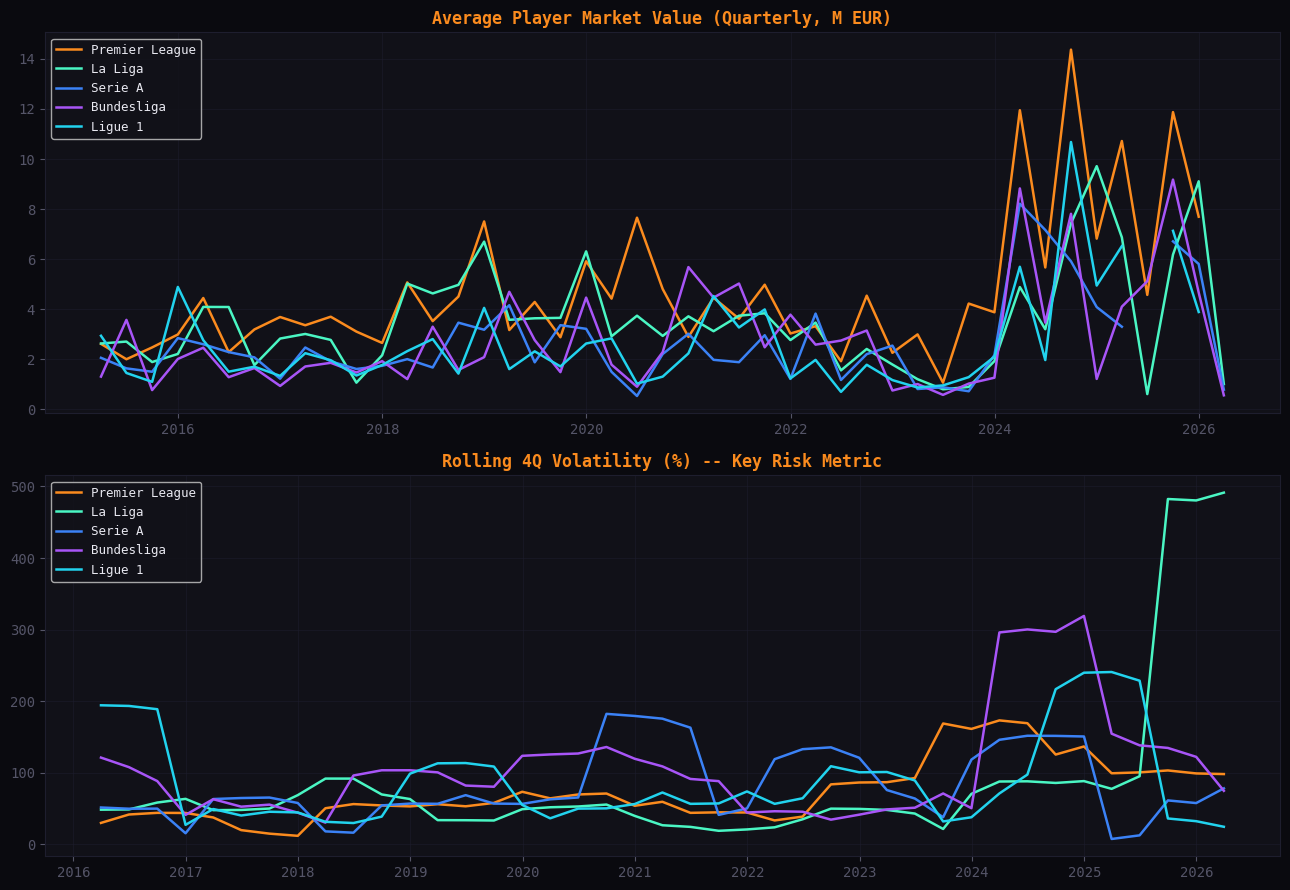

In [4]:

SQL = '''
    SELECT date, player_club_domestic_competition_id as league_id,
        AVG(market_value_in_eur) / 1e6 as avg_value_m
    FROM player_valuations
    WHERE player_club_domestic_competition_id IN ('GB1','ES1','IT1','L1','FR1')
      AND market_value_in_eur > 0 AND date >= '2015-01-01'
    GROUP BY date, league_id
    ORDER BY date, league_id
'''
df_ts = pd.read_sql(SQL, conn)
df_ts['date'] = pd.to_datetime(df_ts['date'])
pivot = df_ts.pivot(index='date', columns='league_id', values='avg_value_m').resample('Q').mean()
vol = pivot.pct_change().rolling(4).std() * 100

fig, axes = plt.subplots(2, 1, figsize=(13, 9))
for i, (lid, color) in enumerate(zip(['GB1','ES1','IT1','L1','FR1'], COLORS)):
    if lid in pivot.columns:
        axes[0].plot(pivot.index, pivot[lid], label=LEAGUE_NAMES[lid], color=color, linewidth=1.8)
        axes[1].plot(vol.index, vol[lid], label=LEAGUE_NAMES[lid], color=color, linewidth=1.8)

axes[0].set_title('Average Player Market Value (Quarterly, M EUR)'); axes[0].legend(fontsize=9); axes[0].grid(True)
axes[1].set_title('Rolling 4Q Volatility (%) -- Key Risk Metric'); axes[1].legend(fontsize=9); axes[1].grid(True)
plt.tight_layout()
plt.savefig('../data/processed/fig_volatility_ts.png', dpi=120, bbox_inches='tight', facecolor='#0a0a0f')
plt.show()


In [5]:
conn.close()
print('Models complete.')

Models complete.
